In [1]:
import numpy as np
import pandas as pd
import fastText
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
model = fastText.load_model('../pretrained/fasttext/wiki.en/wiki.en.bin')

In [3]:
train = pd.read_csv('../data/train_preprocessed.csv')
test = pd.read_csv('../data/test_preprocessed.csv')

x_train_val = train['comment_text'].fillna('FillNaValue').values
x_test = test['comment_text'].fillna('FillNaValue').values

classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train_val = train[classes].values

In [4]:
MAX_FEATURES = 100000

In [5]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(x_train_val) + list(x_test))

In [6]:
x_train_val = tokenizer.texts_to_sequences(x_train_val)
x_test = tokenizer.texts_to_sequences(x_test)

In [7]:
sorted(tokenizer.word_counts.items(),
       reverse=True,
       key=lambda x: x[1])[MAX_FEATURES - 30: MAX_FEATURES]

[('motherjane', 2),
 ('wikiprecedent', 2),
 ('checkmeout', 2),
 ('wabc', 2),
 ('skell', 2),
 ('buttar', 2),
 ('asskickers', 2),
 ('mechatronics', 2),
 ('funnybunny', 2),
 ('oryzomys', 2),
 ('artickle', 2),
 ('coentr', 2),
 ('epoca', 2),
 ('chopa', 2),
 ('pece', 2),
 ('macauley', 2),
 ('liturgically', 2),
 ('mountaineer', 2),
 ('cencored', 2),
 ('nuclearvacuum', 2),
 ('reviewd', 2),
 ('loval', 2),
 ('arrogate', 2),
 ('espcecially', 2),
 ('rancor', 2),
 ('bksimonb', 2),
 ('reneeholle', 2),
 ('philosoph', 2),
 ('fvcking', 2),
 ('possiblility', 2)]

36.0
76.0
153.0
232.0


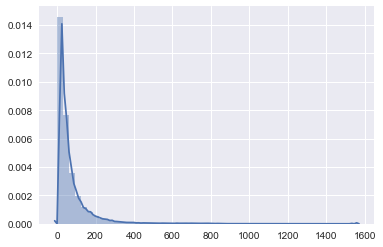

In [8]:
g = sns.distplot(list(map(len, x_train_val)))

print(np.percentile(list(map(len, x_train_val)), 50))
print(np.percentile(list(map(len, x_train_val)), 75))
print(np.percentile(list(map(len, x_train_val)), 90))
print(np.percentile(list(map(len, x_train_val)), 95))

In [7]:
MAX_LENGTH = 150

In [8]:
x_train_val = pad_sequences(x_train_val, maxlen=MAX_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_LENGTH)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val,
                                                  train_size=0.9, random_state=528)

In [10]:
np.save('../data/x_train_100k_L150.npy', x_train)
np.save('../data/x_val_100k_L150.npy', x_val)
np.save('../data/x_test_100k_L150.npy', x_test)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_val.npy', y_val)

In [13]:
def pretrained_from_model(model, max_features, word_index):
    '''
    Arguments:
    file_name --
    max_features --
    word2idx_map --
    
    Returns:
    embedding_matrix -- numpy array
    
    '''
    embed_dim = model.get_word_vector('apple').shape[0]
    embed_matrix = np.zeros((max_features + 1, embed_dim))
    num = 0
    words = set(model.get_words())
    
    for word, idx in word_index.items():
        if word in words:
            num += 1
        if idx > max_features:
            break
        v = model.get_word_vector(word)
        embed_matrix[idx, :] = v
    
    print('Total vocabularies: %d, Load pretrained embedding for %d of them' %
          (max_features, num))
    
    return embed_matrix

In [14]:
embed_matrix = pretrained_from_model(model, MAX_FEATURES, tokenizer.word_index)

Total vocabularies: 100000, Load pretrained embedding for 94027 of them


In [15]:
np.save('../pretrained/numpy_matrix/fastTest.300D.100kFeatures.npy', embed_matrix)

In [16]:
def pretrained_from_file(file, embed_dim, max_features, word_index):
    '''
    Arguments:
    file_name --
    max_features --
    word2idx_map --
    
    Returns:
    embedding_matrix -- numpy array
    
    '''
    embed_dim = model.get_word_vector('apple').shape[0]
    embed_matrix = np.zeros((max_features + 1, embed_dim))
    num = 0
    
    for line in open(file):
        line = line.strip().split(' ')
        word = line[0]
        idx = word_index.get(word)
        if idx is None or idx > max_features:
            continue
        num += 1
        embed_matrix[idx, :] = np.asarray(line[1:], dtype='float32')
    
    print('Total vocabularies: %d, Load pretrained embedding for %d of them' %
          (max_features, num))
    
    return embed_matrix

In [17]:
embed_matrix = pretrained_from_file('../pretrained/glove/glove.840B.300d.txt', 300, MAX_FEATURES, tokenizer.word_index)

Total vocabularies: 100000, Load pretrained embedding for 78350 of them


In [18]:
np.save('../pretrained/numpy_matrix/glove.300D.100kFeatures.npy', embed_matrix)